In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

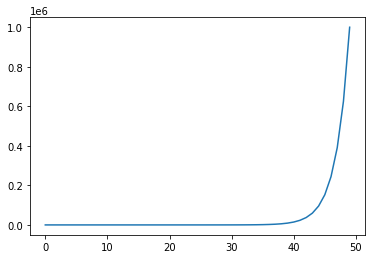

In [2]:
plt.plot(np.logspace(-4, 6))

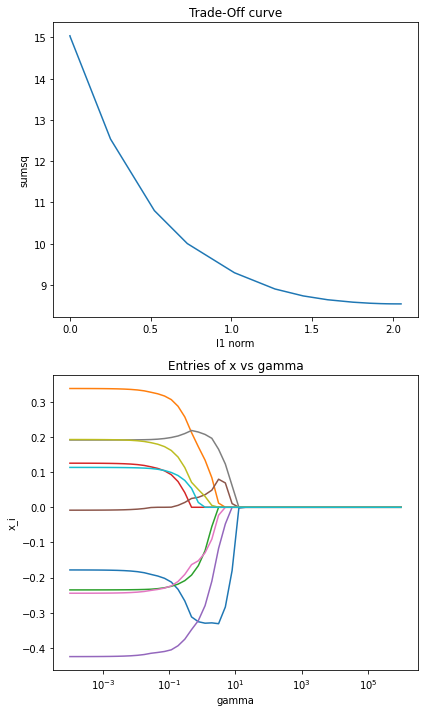

In [3]:
'''
LASSO problem trade-off curves
    cvxpy parameters
'''
# data
n = 15
m = 10
np.random.seed(1)
A = np.random.randn(n,m)
b = np.random.randn(n)
gamma = cp.Parameter(nonneg=True) # must be nonneg due to DCP rules

# problem
x = cp.Variable(m)
error = cp.sum_squares(A@x - b)
obj = cp.Minimize(error + gamma*cp.norm(x,1))
prob = cp.Problem(obj)

# trade-off curve 
# ||Ax-b||^2 vs ||x||_1
sq_penalty = []
l1_penalty = []
x_values = []
gamma_vals = np.logspace(-4, 6)
for val in gamma_vals:
    gamma.value = val
    prob.solve()
    sq_penalty.append(error.value)
    l1_penalty.append(cp.norm(x,1).value)
    x_values.append(x.value)

plt.figure(figsize=(6, 10))

# plot trade-off curve
plt.subplot(211)
plt.plot(l1_penalty, sq_penalty)
plt.xlabel('l1 norm')
plt.ylabel('sumsq')
plt.title('Trade-Off curve')

# plot entries of x vs gammma
plt.subplot(212)
for i in range(m):
    plt.plot(gamma_vals, [xi[i] for xi in x_values])
plt.xlabel('gamma')
plt.ylabel('x_i')
plt.xscale('log')
plt.title('Entries of x vs gamma')

plt.tight_layout()
plt.show()

In [4]:
'''
SDP of form
    minimize tr(CX)
    subject to tr(A_iX) = b_i, i=1,...,p
    X PSD
Variable - X
Problem data - S^n (set of nxn symm matrices)
            C, A_1,...,A_p \in S^n
            b_1,...,b_p \in \R
''' 

# generate random SDP
n = 3
p = 3
np.random.seed(1)
C = np.random.randn(n,n)
A = [] # conditions
b = []
for i in range(p):
    A.append(np.random.randn(n,n))
    b.append(np.random.randn())

# symmetric matrix
X = cp.Variable((n,n), symmetric=True)
constraints = [X >> 0]
constraints += [cp.trace(A[i]@X) == b[i] for i in range(p)]
prob = cp.Problem(cp.Minimize(cp.trace(C@X)), constraints)
prob.solve()

print(prob.value) # optimal value
print(X.value) # solution X

2.654351510231603
[[ 1.60805795 -0.59770492 -0.69576152]
 [-0.59770492  0.22229041  0.24689363]
 [-0.69576152  0.24689363  1.39679885]]


In [5]:
print(np.trace(A[0]@X.value))
print(b[0])
lams, V = np.linalg.eig(X.value)
print(lams)

0.04221368446072571
0.04221374671559283
[2.38287761e+00 8.44267838e-01 1.76352325e-06]


In [6]:
'''
Control problem of form
    minimize \sum_{t=0}^{T-1}{l(x_t, u_t) + l_T(x_T)}
    subject to x_{t+1} = Ax_t + Bu_t
Variable - x, u
'''

# generate data
np.random.seed(1)
n = 8 # states
m = 2 # inputs
T = 50 # horizon
alpha = 0.2
beta = 5
A = np.eye(n) + alpha*np.random.randn(n,n)
B = np.random.randn(n,m)
x_0 = beta*np.random.randn(n)

# two variables to minimize
x = cp.Variable((n, T+1))
u = cp.Variable((m, T))

cost = 0
constraints = []
for t in range(T):
    cost += cp.sum_squares(x[:,t+1]) + cp.sum_squares(u[:,t])
    constraints += [x[:,t+1] == A@x[:,t] + B@u[:,t]]
    constraints += [cp.norm(u[:,t], 'inf') <= 1]
constraints += [x[:,T] == 0, x[:,0] == x_0]
prob = cp.Problem(cp.Minimize(cost), constraints)
prob.solve(solver=cp.ECOS)

/usr/local/lib/python3.8/site-packages/cvxpy/problems/problem.py:1267: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


64470.63768245135

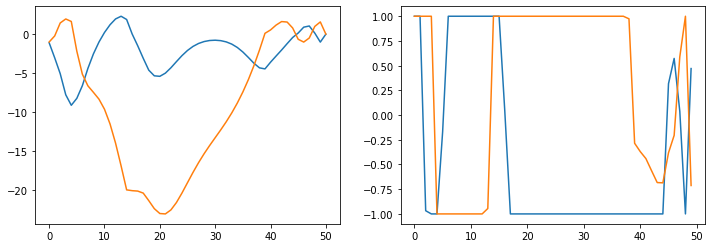

In [7]:
plt.figure(figsize=(12, 4))
plt.subplot(121)
plt.plot(x[0,:].value)
plt.plot(x[1,:].value)
plt.subplot(122)
plt.plot(u[0,:].value)
plt.plot(u[1,:].value)